# Preprocessing ISIC Dataset
## 1. Training Data
### 1.1. Imports and load ground truth 

In [16]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from matplotlib import pyplot as plt


# Load ground truth
gt=pd.read_csv('ISIC2018_Task3_Training_GroundTruth.csv')

gt.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The given format of the ground truth is not suitable for the ML algorithms we wanted to use. Therefore, we had to transform the ground truth into a vector that assigns each image to a number representing the diagnosis.

In [17]:
#Convert csv to one array 
Ytrain=gt['MEL']+ 2*gt['NV'] + 3*gt['BCC'] + 4*gt['AKIEC'] + 5*gt['BKL'] + 6*gt['DF'] + 7*gt['VASC']
Ytrain = Ytrain.astype(int)
Ytrain[0:20]

0     2
1     2
2     2
3     2
4     1
5     2
6     5
7     1
8     2
9     1
10    2
11    2
12    6
13    2
14    2
15    2
16    2
17    1
18    5
19    2
dtype: int32

### 1.2. Load data 

One of the biggest challenges with this dataset was dealing with the overrepresentation of some classes, which can have a negative impact on the training process. To ensure that each class type has the same number of images, we determined the smallest amount of representations and loaded only that many images for each type.

In [18]:
def reduceDataset(Y,img_names, numClasses):
    # count all the values in the ground truth
    counts = np.bincount(Y)
    counts= np.delete(counts, 0)
    print(counts)

    # determine the least represented value
    rare_value = np.argmin(counts)
    num_representations = counts[rare_value]

    print("Least represented value:", rare_value+1, "with",num_representations , "representations")

    # select num_representations images for each class
    counter = np.zeros((numClasses))
    img_index =  []
    newY=[]
    for index, elem in enumerate(Y):
        x = int(elem) -1
        if counter[x]< num_representations:
            img_index = np.append(img_index, (img_names[index] + ".jpg"))
            counter[x]+=1
            newY = np.append(newY, elem)
        if sum(counter)>= numClasses*num_representations:
            break
    print(img_index.size, "images left.")
    return img_index, newY

# save image lables in an array
img_names = gt['image']

# Reduce the ground trouth and estimate which images should be loaded into the training set
train_index, Ytrain = reduceDataset(Ytrain, img_names,7)

[1113 6705  514  327 1099  115  142]
Least represented value: 6 with 115 representations
805 images left.


In [19]:
def loadPics(directory, x, y, index):
    data = []
    # Iterate through files in the specified directory
    for file in os.listdir(directory):
         # Check if the file is from type ".jpg"
         if file.endswith(".jpg") and file in index:
             #Take the image, resize it, covert it into an numpy array and append it to our data list
             img = Image.open(os.path.join(directory, file))
             img = img.resize((x,y))
             imgArray = np.array(img)
             data.append(imgArray)

    #Convert data list to np array
    data = np.array(data)
    return data

#load training data
data1 = loadPics("ISIC2018_Task3_Training_Input", 60,45, train_index)

#Check the shape of our numpy data array
data1.shape

(805, 45, 60, 3)

### 1.3. Data Augmentation

Reducing the dataset helped to overcome the problem of over-representation of classes, but in general it would be more helpful to have more images in the dataset than less. Therefore, we used data augmentation to create more image data by taking existing images, transforming them and adding the newly created images to our dataset.

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# Use ImageDataGenerator to create an generator 
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

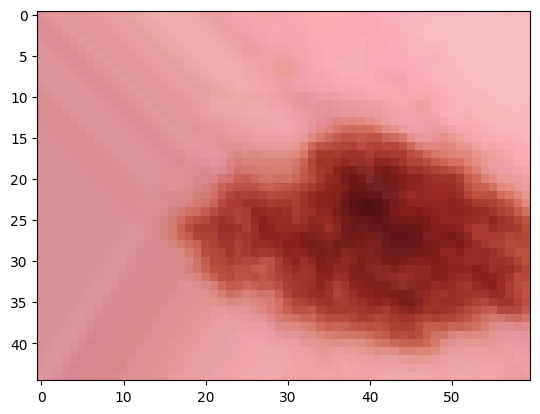

In [22]:
# plot sample image
plt.imshow(datagen.random_transform(data1[2,:,:]))
plt.show()
plt.close()

In [24]:
newXtrain = data1.copy()
newYtrain = Ytrain.copy()

# Apply data augmentation two times for every image
for _ in range(2):
    augmented_data = []
    # for every image in the dataset (805 images)
    for img in range(805):
        augmentedImage = datagen.random_transform(data1[img,:,:,:])
        augmented_data.append(augmentedImage)
    data = np.array(augmented_data)
    # add new data to excisting data
    newXtrain = np.concatenate((newXtrain, data), axis=0)
    newYtrain = np.concatenate((newYtrain, Ytrain), axis=0)



In [25]:
# check the new size of the training set
newXtrain.shape

(2415, 45, 60, 3)

### 1.4. Reshaping

Reshape data in order to have one image per row

In [27]:
reshapeData = newXtrain.reshape(newXtrain.shape[0], newXtrain.shape[1]*newXtrain.shape[2]*newXtrain.shape[3])
# Controll shape
reshapeData.shape

(2415, 8100)

### 1.5. Normalization

Normalize data by dividing by the maximum value of the pixels (255)

In [28]:
normData = reshapeData / 255.
print('normData.min()', normData.min())
print('normData.max()', normData.max())

normData.min() 0.0
normData.max() 1.0


### 1.6. Mean removal

Remove the mean from each pixel

In [29]:
normData = normData - normData.mean(axis=0)
# Control if the means are now approx. 0
normData.mean(axis=0)

array([ 1.29130661e-15,  7.02911389e-16, -1.03956411e-15, ...,
        3.06991607e-15, -9.55343465e-16,  1.58925093e-16])

### 1.7 ZCA whitening

Finally, as in the first lab of this course, we applied whitening to reduce redundancy in the image data. This can help to highlight the structures and features in the image for the learning algorithm.

In [30]:
#Calculate the covariance matrix of the normalized data
cov = np.cov(normData, rowvar=False)
# Control shape of covariance matrix
print(cov.shape)

#Perform Singular Value Decomposition (SVD) on the covariance matrix 'cov'
U,S,V = np.linalg.svd(cov)
#Set a small constant 'epsilon' to avoid division by zero in the next step
epsilon = 0.1
# Perform Zero-phase Component Analysis whitening on the normalized data
DataZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(normData.T).T
#Rescale the ZCA-whitened data 'DataZCA' to the range [0, 1]
DataZCA_rescaled = (DataZCA - DataZCA.min()) / (DataZCA.max() - DataZCA.min())
print('min:', DataZCA_rescaled.min())
print('max:', DataZCA_rescaled.max())

(8100, 8100)
min: 0.0
max: 1.0


### 1.8. Plot sample image

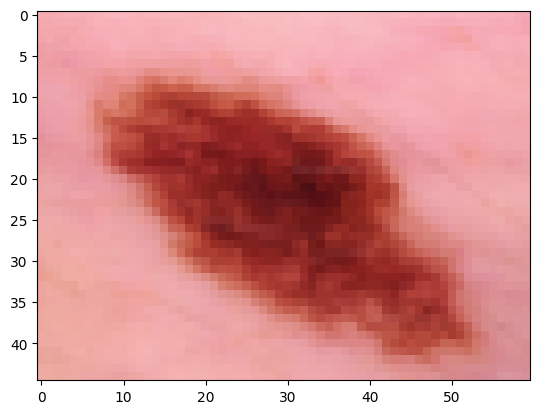

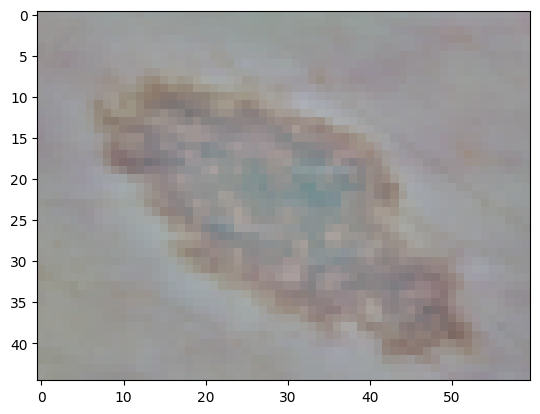

In [35]:
Xtrain = DataZCA_rescaled

#Function which takes a image and plots it
x = 60
y = 45
def plotImage(X):
 plt.imshow(X.reshape(y,x,3))
 plt.show()
 plt.close()

#Plot third image before and after whitening
plotImage(reshapeData[2, :])
plotImage(Xtrain[2, :])

## 2. Test Data
We will repeat the same steps as above for the test data.
### 2.1. Imports and load ground truth

In [36]:
# Load ground truth
Ytest=pd.read_csv('ISIC2018_Task3_Test_GroundTruth.csv')
test_names = Ytest['image']
#Convert csv to one array (ToDo: check conversion to numpy array and save the classes
Ytest=Ytest['MEL']+ 2*Ytest['NV'] + 3*Ytest['BCC'] + 4*Ytest['AKIEC'] + 5*Ytest['BKL'] + 6*Ytest['DF'] + 7*Ytest['VASC']
Ytest = Ytest.astype(int)

### 2.2. Load data

In [37]:
test_index, Ytest = reduceDataset(Ytest, test_names,7)

[171 909  93  43 217  44  35]
Least represented value: 7 with 35 representations
245 images left.


In [38]:
data2 = loadPics("ISIC2018_Task3_Test_Input", 60,45, test_index)
#Check the shape of our numpy data array
data2.shape

(245, 45, 60, 3)

### 2.3. Data Augmentation

In [39]:
newXtest = data2.copy()
newYtest = Ytest.copy()

# Apply data augmentation two times for every image
for _ in range(2):
    augmented_data = []
    # for every image in the dataset (245 images)
    for img in range(245):
        augmentedImage = datagen.random_transform(data2[img,:,:,:])
        augmented_data.append(augmentedImage)
    data = np.array(augmented_data)
    # add new data to excisting data
    newXtest = np.concatenate((newXtest, data), axis=0)
    newYtest = np.concatenate((newYtest, Ytest), axis=0)

In [40]:
# check the new size of the training set
newXtest.shape

(735, 45, 60, 3)

### 2.4. Reshaping

In [56]:
#Reshape data in order to have one image per row
reshapeData2 = newXtest.reshape(newXtest.shape[0], newXtest.shape[1]*newXtest.shape[2]*newXtest.shape[3])
# Controll shape
print(reshapeData2.shape)

(735, 8100)


### 2.5. Normalization

In [57]:
#Normalize data by dividing by the maximum value of the pixels (255)
normData2 = reshapeData2 / 255
print('normData2.min()', normData2.min())
print('normData2.max()', normData2.max())

normData2.min() 0.0
normData2.max() 1.0


### 2.6. Mean Removal

In [58]:
#Remove the mean from each pixel
normData2 = normData2 - normData2.mean(axis=0)
# Control if the means are now approx. 0
print(normData2.mean(axis=0))

[ 6.79728382e-16 -6.12208696e-16  6.49518232e-18 ...  1.22456844e-15
  5.28224479e-16  6.76254215e-16]


### 1.7 ZCA whitening

In [60]:
#Calculate the covariance matrix of the normalized data
cov2 = np.cov(normData2, rowvar=False)
# Control shape of covariance matrix
print(cov2.shape)

#Perform Singular Value Decomposition (SVD) on the covariance matrix 'cov'
U2,S2,V2 = np.linalg.svd(cov2)
#Set a small constant 'epsilon' to avoid division by zero in the next step
epsilon2 = 0.1
# Perform Zero-phase Component Analysis whitening on the normalized data
DataZCA2 = U2.dot(np.diag(1.0/np.sqrt(S2 + epsilon2))).dot(U2.T).dot(normData2.T).T
#Rescale the ZCA-whitened data 'DataZCA' to the range [0, 1]
DataZCA_rescaled2 = (DataZCA2 - DataZCA2.min()) / (DataZCA2.max() - DataZCA2.min())
print('min:', DataZCA_rescaled2.min())
print('max:', DataZCA_rescaled2.max())

(8100, 8100)
min: 0.0
max: 1.0


### 2.8. Plot sample image

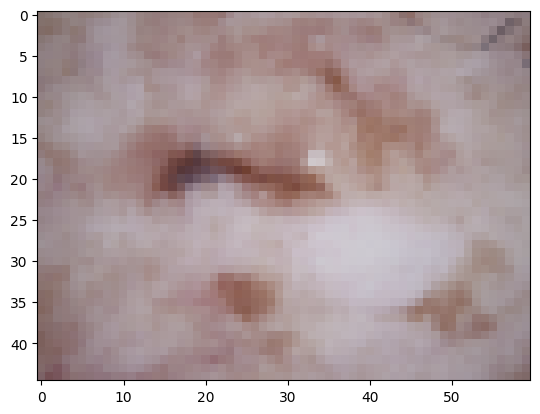

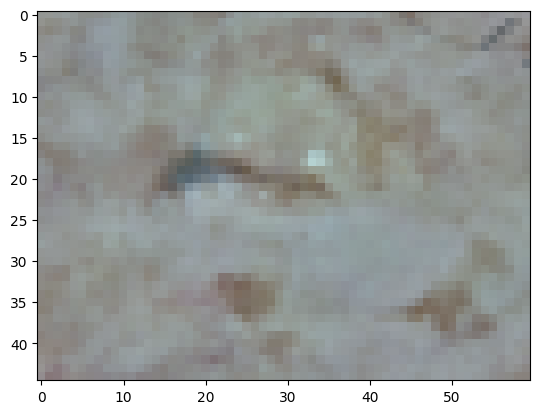

In [61]:
Xtest = DataZCA_rescaled2

#Plot third image before and after whitening
#plotImage(newXtest[2, :,:,:])
plt.imshow(data2[2,:,:,:])
plt.show()
plt.close()
plotImage(Xtest[2, :])

## 3. Save preprocessed data

In [63]:
# Save the NumPy array to an npy file
np.save('3rdISICTrainpics_preprocessed.npy', Xtrain)
np.save('3rdISICTestpics_preprocessed.npy', Xtest)
np.save('3rdISICTrainGT_preprocessed.npy', newYtrain)
np.save('3rdISICTestGT_preprocessed.npy', newYtest)